
<h1>Задание 1</h1>

У вас есть небольшой искусственный датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/customer-shopping-trends-dataset/data   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Задание 1.1</h2>

На основании этих данных необходимо составить максимальное(но не менее пяти) количество гипотез о корреляциях между отдельными столбцами и проверить их.

При этом при составлении гипотез можно рассматривать не полный df, а именно выборки (например: "женщины старше 40 лет покупают в основном осенью")

In [ ]:
data = pd.read_csv("shopping_trends_updated.csv")
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

In [ ]:
df.head(10)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
5,6,46,Male,Sneakers,Footwear,20,Wyoming,M,White,Summer,2.9,Yes,Standard,Yes,Yes,14,Venmo,Weekly
6,7,63,Male,Shirt,Clothing,85,Montana,M,Gray,Fall,3.2,Yes,Free Shipping,Yes,Yes,49,Cash,Quarterly
7,8,27,Male,Shorts,Clothing,34,Louisiana,L,Charcoal,Winter,3.2,Yes,Free Shipping,Yes,Yes,19,Credit Card,Weekly
8,9,26,Male,Coat,Outerwear,97,West Virginia,L,Silver,Summer,2.6,Yes,Express,Yes,Yes,8,Venmo,Annually
9,10,57,Male,Handbag,Accessories,31,Missouri,M,Pink,Spring,4.8,Yes,2-Day Shipping,Yes,Yes,4,Cash,Quarterly


In [ ]:
df.describe().applymap(lambda x:f'{x:.2f}')[['Age','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]

<ipython-input-15-9deda90d9bec>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.describe().applymap(lambda x:f'{x:.2f}')[['Age','Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']]


,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,3900.00,3900.00,3900.00,3900.00
mean,44.07,59.76,3.75,25.35
std,15.21,23.69,0.72,14.45
min,18.00,20.00,2.50,1.00
25%,31.00,39.00,3.10,13.00
50%,44.00,60.00,3.70,25.00
75%,57.00,81.00,4.40,38.00
max,70.00,100.00,5.00,50.00


In [ ]:
df.describe(include='object')[['Gender','Item Purchased', 'Category', 'Location',
                               'Size', 'Color', 'Season', 'Subscription Status',
                               'Shipping Type', 'Discount Applied', 'Promo Code Used',
                               'Payment Method', 'Frequency of Purchases']]


,Gender,Item Purchased,Category,Location,Size,Color,Season,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Payment Method,Frequency of Purchases
count,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900,3900
unique,2,25,4,50,4,25,4,2,6,2,2,6,7
top,Male,Blouse,Clothing,Montana,M,Olive,Spring,No,Free Shipping,No,No,PayPal,Every 3 Months
freq,2652,171,1737,96,1755,177,999,2847,675,2223,2223,677,584


<h2>Задание 1.2</h2>

Помимо гипотез:
* найдите самый популярный товар
* постройте распределение покупателей по полу
* определите, какой пол (и отдельно возраст) покупает больше всего, чаще всего, самые дорогие товары
* определите, есть ли зависимость между цветом одежды и сезоном.
* посчитайте наш сезонный mau (уникальных пользователей за сезон) и его динамику.
* найдите самую популярную букву в названии одежды.

In [ ]:
#найдите самый популярный товар
df_value_counts = df['Item Purchased'].value_counts()
max_frequency = max(df_value_counts)
most_popular_values = df_value_counts[df_value_counts == max_frequency]
print(f'Самые популярные товары: {most_popular_values}')


Самые популярные товары: Item Purchased
Blouse     171
Jewelry    171
Pants      171
Name: count, dtype: int64


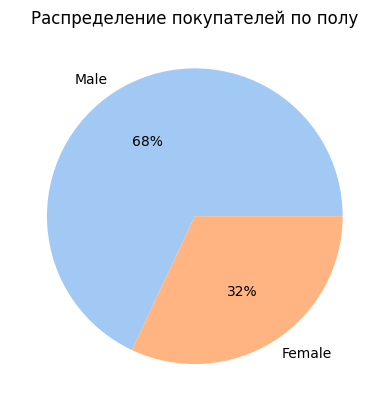

In [ ]:
#постройте распределение покупателей по полу
gender_values = df['Gender'].value_counts().values
gender_labels = df['Gender'].value_counts().index

colors = sns.color_palette('pastel')
plt.pie(x=gender_values, labels=gender_labels, autopct='%1.0f%%', colors=colors)
plt.title("Распределение покупателей по полу")
plt.show()

In [ ]:
#определите, какой пол (и отдельно возраст) покупает больше всего

gender_purchase_amount = df['Gender'].mode()
age_purchase_amount = df['Age'].mode()


print(f'Больше всего покупают люди с полом: {gender_purchase_amount.values}')
print(f'Больше всего покупают люди с возрастом: {age_purchase_amount.values}')


Больше всего покупают люди с полом: ['Male']
Больше всего покупают люди с возрастом: [69]


In [ ]:
#определите, какой пол покупает чаще всего
frequency_map = {
    'Weekly': 52,          # Раз в неделю, 52 раза в год
    'Bi-Weekly': 104,      # Два раза в неделю, 104 раза в год
    'Fortnightly': 26,     # Раз в две недели, 26 раз в год
    'Monthly': 12,         # Раз в месяц, 12 раз в год
    'Quarterly': 4,        # Раз в квартал, 4 раза в год
    'Every 3 Months': 4,   # Раз в 3 месяца (эквивалент Quarterly), 4 раза в год
    'Annually': 1          # Раз в год, 1 раз в год
}

#Сброс индексов
grouped_counts = (
      df.groupby("Gender")['Frequency of Purchases']
      .value_counts()
      .reset_index(name='Counts')
)

#Новый столбец, где преобразуем значения Frequency of Purchases' в числа
grouped_counts['Value_of_frequency'] = (
    grouped_counts['Frequency of Purchases']
    .map(frequency_map)
)

#Умножаем столбцы 'Counts' и 'Value_of_frequency', получаем общее количество покупок
grouped_counts['Total_purchases'] = (
    grouped_counts['Value_of_frequency']
    * grouped_counts['Counts']
)

#Суммируем покупки по полу
grouped_counts_by_gender = grouped_counts.groupby('Gender')['Total_purchases'].sum()

#Считаем количество записей по полу
purchase_by_gender = df['Gender'].value_counts()

#Делим расчетную частоту на количество записей, чтобы получить
#нормальзованную частоту по  полу
normalized_purchases_by_gender = grouped_counts_by_gender / purchase_by_gender

#Выводим пол, который чаще совершал покупки
print(normalized_purchases_by_gender.idxmax())

Female


In [ ]:
#определите люди какого возраста покупают чаще всего

frequency_map = {
    'Weekly': 52,          # Раз в неделю, 52 раза в год
    'Bi-Weekly': 104,      # Два раза в неделю, 104 раза в год
    'Fortnightly': 26,     # Раз в две недели, 26 раз в год
    'Monthly': 12,         # Раз в месяц, 12 раз в год
    'Quarterly': 4,        # Раз в квартал, 4 раза в год
    'Every 3 Months': 4,   # Раз в 3 месяца (эквивалент Quarterly), 4 раза в год
    'Annually': 1          # Раз в год, 1 раз в год
}

#Сброс индексов
grouped_counts = (
      df.groupby("Age")['Frequency of Purchases']
      .value_counts()
      .reset_index(name='Counts')
)

#Новый столбец, где преобразуем значения Frequency of Purchases' в числа
grouped_counts['Value_of_frequency'] = (
    grouped_counts['Frequency of Purchases']
    .map(frequency_map)
)

#Умножаем столбцы 'Counts' и 'Value_of_frequency', получаем общее количество покупок
grouped_counts['Total_purchases'] = (
    grouped_counts['Value_of_frequency']
    * grouped_counts['Counts']
)

#Суммируем покупки по возрасту
grouped_counts_by_gender = grouped_counts.groupby('Age')['Total_purchases'].sum()

#Считаем количество записей по возрасту
purchase_by_gender = df['Age'].value_counts()

#Делим расчетную частоту на количество записей, чтобы получить
#нормальзованную частоту по  возрасту
normalized_purchases_by_gender = grouped_counts_by_gender / purchase_by_gender

#Выводим возраст людей, которые чаще совершал покупки
print(normalized_purchases_by_gender.idxmax())

26


In [ ]:
# Группируем по полу и находим максимальную сумму покупок для каждого пола
max_purchase_by_gender = df.groupby("Gender")['Purchase Amount (USD)'].max()

# Группируем по возрасту и находим максимальную сумму покупок для каждого возраста
max_purchase_by_age = df.groupby("Age")['Purchase Amount (USD)'].max()

# Выводим пол с самой дорогой покупкой
max_gender_purchase = max_purchase_by_gender.idxmax()
max_gender_value = max_purchase_by_gender.max()


# Выводим возраст с самой дорогой покупкой
max_age_purchase = max_purchase_by_age.idxmax()
max_age_value = max_purchase_by_age.max()

print(f"Пол, покупающий самые дорогие товары: {max_gender_purchase} (с суммой {max_gender_value} USD)")
print(f"Возраст, покупающий самые дорогие товары: {max_age_purchase} (с суммой {max_age_value} USD)")


Пол, покупающий самые дорогие товары: Female (с суммой 100 USD)
Возраст, покупающий самые дорогие товары: 18 (с суммой 100 USD)


<h1>Задание 2</h1>

У нас есть данные о потреблении алкоголя в мире https://github.com/fivethirtyeight/data/tree/master/alcohol-consumption.

Загрузите их и изучите, где же люди пьют больше вина, пива и других спиртных напитков.

<h1>Задание 3</h1>

У нас есть полный каталог всех случаев, когда кто-то проклинал или истекал кровью в фильме Квентина Тарантино. https://github.com/fivethirtyeight/data/tree/master/tarantino

Определите:

* число проклятий, летальных исходов и их соотношение по фильмам

* частоту употребления конкретных проклятий

* распределение времени между проклятиями